This model is a character-level neural network with an embedding layer, a single hidden layer using tanh, and a softmax output. Several important optimizations are applied to stabilize training, improve convergence, and reduce loss.

In [3]:
import torch
import torch.nn.functional as F

In [4]:
words = open("names.txt").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
#build the dataset and dataloader
block_size = 3

def build_dataset(words):
    x, y = [], []

    for w in words:
        # print(w)
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix]  # crop and append

    x = torch.tensor(x)
    y = torch.tensor(y)
    return x, y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

xtr, ytr = build_dataset(words[:n1])        #80%
xdev, ydev = build_dataset(words[n1:n2])    #10%
xtest, ytest = build_dataset(words[n2:])    #10%


***Reduced Initial Variance***

Large initial weights can push activations into saturation regions of tanh, causing vanishing gradients

Small initial values:
Keep activations near zero

Ensure gradients flow during early training

Prevent overly confident wrong predictions in softmax

***Kaiming (He) Initialization***

Kaiming (He) initialization scales weights based on the number of input connections:

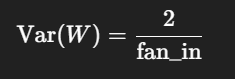

It is designed to preserve activation variance as signals propagate through deep networks.

In [22]:
n_embed = 10
n_hidden = 200 #number of neurons in hidden layer

g = torch.Generator().manual_seed(2147483647)
c = torch.randn((27, n_embed), generator = g)
w1 = torch.randn((n_embed * block_size, n_hidden), generator = g) * (5/3) / (n_embed * block_size**0.5) #Kaiming initialization for tanh activations 
b1 = torch.randn((n_hidden), generator = g) * 0.01                      #biases are usually initialized to zero or small values
w2 = torch.randn((n_hidden, 27), generator = g) * 0.01                  #final layer weights are usually initialized to small values near zero because initial loss can be high due to softmax confidently wrong
b2 = torch.randn((27), generator = g) * 0                               #final layer biases are usually initialized to small values near zero or zero

parameters = [c, w1, b1, w2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


***Output Layer Near-Zero Initialization***

The final layer (w2, b2) is initialized very close to zero.

Benefit:

Softmax outputs are initially close to uniform

Prevents very high initial loss

Leads to smoother early optimization

In [23]:
max_steps = 200000
batch_size = 32
lossi = []

for epochs in range(max_steps):
    #mini-batch construc
    ix = torch.randint(0,xtr.shape[0], (batch_size,), generator = g)
    xb, yb = xtr[ix], ytr[ix]

    #forward pass
    emb = c[xb]                             #embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)     # concatenate the vectors
    hpreact = embcat @ w1 + b1              # hidden layer pre-activation
    h = torch.tanh(hpreact)                 # hidden layer activation
    logits = h @ w2 + b2                    # output layer
    loss = F.cross_entropy(logits, yb)      #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update parameters
    lr = 0.1 if epochs < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if epochs % 10000 == 0:
        print(f"{epochs:7d}/{max_steps:7d}: loss {loss.item(): .4f}")
    lossi.append(loss.item())



      0/ 200000: loss  3.3066
  10000/ 200000: loss  2.1917
  20000/ 200000: loss  2.2589
  30000/ 200000: loss  2.4192
  40000/ 200000: loss  1.9121
  50000/ 200000: loss  2.4630
  60000/ 200000: loss  2.3133
  70000/ 200000: loss  2.0910
  80000/ 200000: loss  2.2496
  90000/ 200000: loss  2.1689
 100000/ 200000: loss  1.8757
 110000/ 200000: loss  2.2006
 120000/ 200000: loss  1.9213
 130000/ 200000: loss  2.3698
 140000/ 200000: loss  2.3106
 150000/ 200000: loss  2.2013
 160000/ 200000: loss  1.8343
 170000/ 200000: loss  1.8048
 180000/ 200000: loss  1.8912
 190000/ 200000: loss  1.8390


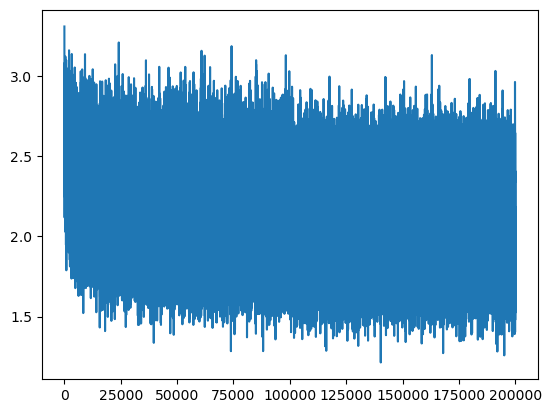

In [24]:
import matplotlib.pyplot as plt
# plt.plot([1,2,3],[1,5,6])
plt.plot(lossi)

In [25]:
@torch.no_grad() #This decorator disables gradient tracking
def split_loss(split):
    x,y  = {
        'train': (xtr, ytr),
        'dev': (xdev, ydev),
        'test': (xtest, ytest)
    }[split]

    emb = c[x]
    hpreact = emb.view(emb.shape[0],-1) @ w1 + b1
    h = torch.tanh(hpreact)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss: {loss.item():.4f}")
    
split_loss('train')
split_loss('dev')

train loss: 2.0617
dev loss: 2.1170


In [30]:
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):

    context = [0]*block_size # start with all dots
    out = []
    while True:    

        emb = c[torch.tensor([context])]                #(1, block_size, n_embed)
        hpreact = emb.view(emb.shape[0],-1) @ w1 + b1   #(1, n_hidden)
        h = torch.tanh(hpreact)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim = 1)
        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator = g).item()
        #slide the context window and add the new character
        context = context[1:] + [ix]
        out.append(ix)
        #break if we generate the end token
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)[:-1])

    

carlah
amelle
khyimish
thtyn
kanden
jazhubbie
esara
kaeli
nellara
chaiir
kaleigh
ham
joce
quinn
saline
livabi
waythagiefryn
kai
eveigh
brex
